In [28]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

#Define ETFs for expansion and contraction phases
etfs_expansion = ['XLK', 'XLY', 'XLI', 'XLF', 'XLE']
etfs_contraction = ['XLI', 'XLV', 'XLU', 'XLP']

#Download ETF data from Yahoo Finance
all_etfs = etfs_expansion + etfs_contraction
etf_prices = yf.download(all_etfs, start='1990-03-01', end = '2020-04-30')['Adj Close']

#Handle missing data by forward-filling prices
etf_prices = etf_prices.ffill()

# Display the first few rows of prices to check data
print(etf_prices.head())

[*********************100%%**********************]  8 of 8 completed

Ticker            XLE        XLF        XLI        XLK        XLP        XLU  \
Date                                                                           
1998-12-22  12.034075  11.425530  14.745356  24.064358  14.558567  12.181782   
1998-12-23  12.284619  11.594006  15.002656  24.639275  14.910512  12.130733   
1998-12-24  12.219964  11.670588  15.200575  24.545420  14.884757  12.354075   
1998-12-28  12.155306  11.517428  15.279754  24.615818  14.798925  12.290259   
1998-12-29  12.276530  11.639958  15.497475  24.686218  15.125115  12.494461   

Ticker            XLV        XLY  
Date                              
1998-12-22  17.233088  18.995110  
1998-12-23  17.620354  19.076691  
1998-12-24  17.727919  19.426296  
1998-12-28  17.469757  19.251495  
1998-12-29  17.857021  19.671021  


In [29]:
# Step 4: Define the economic phases
expansion_periods = [('1998-12-22', '2001-03-01'),
                     ('2001-11-01', '2007-12-01'),
                     ('2009-06-01', '2020-02-01'),
                     ('2020-04-01','2024-01-01')]

contraction_periods = [
                       ('2001-03-01', '2001-11-01'),
                       ('2007-12-01', '2009-06-01'),
                       ('2020-02-01', '2020-04-01')]

#the dates that have 0 or even index are contraction dates, the dates that have odd index are expansion
start_dates = ['1998-12-22','2001-03-01','2001-11-01','2007-12-01','2009-06-01','2020-02-01','2020-04-01']
end_dates = ['2001-03-01','2001-11-01','2007-12-01','2009-06-01','2020-02-01','2020-04-01','2024-01-01']
#the method in which we will access the contraction dates will be using the 0 or even index and expansion using the odd index

In [30]:
#here we are defining the initial investnment amount that we are starting off with for backtesting
global amount_to_invest
global values_of_portfolio
amount_to_invest = 100000
values_of_portfolio = pd.Series()
# Step 5: Function to invest in ETFs during a period
#loop from 0 to the length of dates to invest and if statements to determine if it is a contraction or expansion
def invest(start_date, end_date, period_etfs, etf_prices, amount_to_invest,values_of_portfolio):

    #get the prices for the respective etfs for the period we are investing in
    first_day_period_prices = etf_prices[(etf_prices.index >= start_date) & (etf_prices.index <= end_date)][period_etfs]

    # Invest equally in the given ETFs
    amount_per_etf = amount_to_invest / len(period_etfs)
    #get the number of shares we will be investing in for each etf
    num_shares = amount_per_etf / first_day_period_prices.iloc[0]

    #multiply the intial number of shares bought with the daily price of the respective etfs
    worth = num_shares * first_day_period_prices

    #value of the shares column
    worth['value'] = worth.apply(np.sum, axis=1)
    
    values_of_portfolio=pd.concat([pd.Series(values_of_portfolio), pd.Series(worth['value'])])

    #update the amount to invest to the value of the portfolio
    amount_to_invest = worth.iloc[-1,-1]
    
    #return the latest amount of the portfolio
    return (amount_to_invest,values_of_portfolio)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Final portfolio value on 2024-01-01: $564,865.10


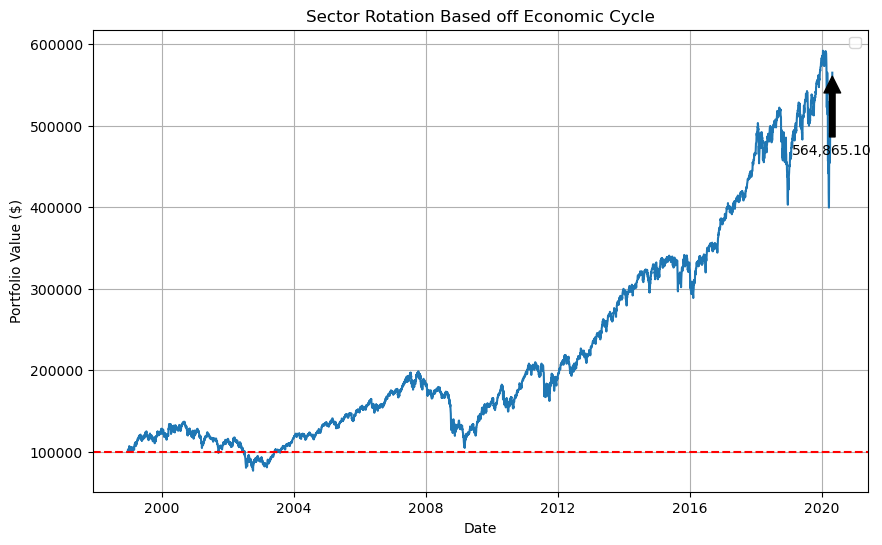

In [31]:
for i in range(len(start_dates)):
    
    if i == 0 or i%2==0:
        #take the value that is held in current holdings and invest in expansionary etfs
        result = invest(start_dates[i],end_dates[i],etfs_expansion,etf_prices,amount_to_invest,values_of_portfolio)
        
        amount_to_invest = result[0]
    
        values_of_portfolio = result[1]
    elif i%2==1:
        #take the value that is held in current holdings and invest in contractionary etfs
        #here depending on the if, we will input the contraction etfs and use the contraction etf_prices
        result = invest(start_dates[i],end_dates[i],etfs_contraction,etf_prices,amount_to_invest,values_of_portfolio)
        amount_to_invest = result[0]
        values_of_portfolio = result[1]
        

final_portfolio_value = amount_to_invest
print(f"Final portfolio value on 2024-01-01: ${values_of_portfolio[-1]:,.2f}")
plt.figure(figsize=(10,6))
plt.plot(values_of_portfolio, label='')
plt.title('Sector Rotation Based off Economic Cycle')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
# Get the last data point
last_date = values_of_portfolio.index[-1]
last_value = values_of_portfolio.iloc[-1]

# Annotate the last point
plt.annotate(f'{last_value:,.2f}',  # Text to display
             xy=(last_date, last_value),  # Coordinates of the point
             xytext=(last_date, last_value - 100000),  # Position of the text
             arrowprops=dict(facecolor='black', shrink=0.05),  # Arrow properties
             fontsize=10,  # Font size
             color='black',  # Text color
             horizontalalignment='center',  # Text alignment
             )
plt.grid(True)
plt.axhline(y=100000, color='red', linestyle='--', label='Initial Investment')

plt.show()

plt.show()

Let's determine some metrics to evaluate the performance of our sector rotation strategy

In [32]:

def sharpe_ratio(daily_returns):
    risk_free_rate = 0.01 / 252  # Adjusting annual risk-free rate to daily
    mean_daily_return = daily_returns.mean()
    std_dev = daily_returns.std()
    return (mean_daily_return - risk_free_rate) / std_dev


def value_at_risk(daily_returns):
    confidence_level = 0.05  # 5% VaR
    return np.percentile(daily_returns, 100 * confidence_level)


def max_draw_down(daily_returns):
    rolling_max = daily_returns.cummax()
    drawdown = (daily_returns - rolling_max) / rolling_max
    return drawdown.min()


def volatility(daily_returns):
    std_dev = daily_returns.std()
    return std_dev * np.sqrt(252)  # Annualized volatility

def total_returns(values_of_portfolio):
    beginning_value = values_of_portfolio.iloc[0]  # First value in the series
    ending_value = values_of_portfolio.iloc[-1]
    return ((ending_value - beginning_value) / beginning_value) * 100

In [33]:
daily_returns_sector_rot = values_of_portfolio.pct_change().dropna()

# Output the results for sector rotation
print('sharpe ratio (sector rotation): ', sharpe_ratio(daily_returns_sector_rot))
print('value at risk (sector rotation): ', value_at_risk(daily_returns_sector_rot))
print('maximum drawdown (sector rotation): ', max_draw_down(daily_returns_sector_rot))
print('annualised volatility (sector rotation): ', volatility(daily_returns_sector_rot))
print('total returns (sector rotation) % ', total_returns(values_of_portfolio))

sharpe ratio (sector rotation):  0.029425897837253474
value at risk (sector rotation):  -0.01927792098977158
maximum drawdown (sector rotation):  -2.128858528487562
annualised volatility (sector rotation):  0.19178815470549612
total returns (sector rotation) %  464.8651046484286


[*********************100%%**********************]  3 of 3 completed


881931.9723328308


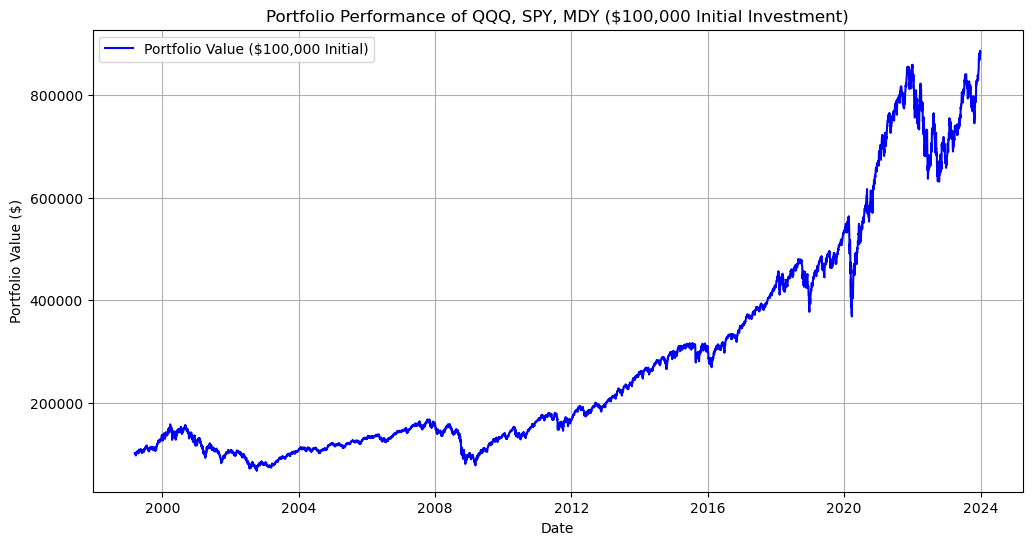

In [34]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Download Historical Data
etfs = ['SPY', 'QQQ','MDY']
start_date = '1998-12-22'
end_date = '2024-01-01'

# Fetch the data
etf_prices = yf.download(etfs, start=start_date, end=end_date)['Adj Close']

# Step 2: Calculate Daily Returns
etf_returns = etf_prices.pct_change().dropna()

# Step 3: Portfolio Allocation (Equal weights)
weights = np.array([0.33, 0.33,0.34])  # 50% in SPY and 50% in QQQ
portfolio_returns = (etf_returns * weights).sum(axis=1)

# Step 4: Calculate Cumulative Returns and Portfolio Value
initial_investment = 100000
cumulative_returns = (1 + portfolio_returns).cumprod() * initial_investment
print(cumulative_returns[-1])
# Step 5: Plot the Portfolio Performance
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Portfolio Value ($100,000 Initial)', color='blue')
plt.title('Portfolio Performance of QQQ, SPY, MDY ($100,000 Initial Investment)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid()
plt.show()


In [35]:
daily_returns = cumulative_returns.pct_change().dropna()

print('sharpe ratio portfolio: ', sharpe_ratio(daily_returns))
print('value at risk portfolio: ', value_at_risk(daily_returns))
print('maximum drawdown portfolio: ', max_draw_down(daily_returns))
print('annualised volatility portfolio: ', volatility(daily_returns))
print('total returns portfolio % ', total_returns(cumulative_returns))

sharpe ratio portfolio:  0.02928712070367905
value at risk portfolio:  -0.022080733822529213
maximum drawdown portfolio:  -2.857143290656217
annualised volatility portfolio:  0.2183806454460042
total returns portfolio %  776.8058022956407
